Feature Engineering and feature selection.

Summary:


In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = '../data/clickdata.csv'
df = pd.read_csv(file_path)

In [3]:
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Browser Webview','Browser')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Robot Mobile','Robot')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Special','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Mobile App','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Cloud Application','Other')

In [4]:
# Convert epoch_ms to datetime
df['datetime'] = pd.to_datetime(df['epoch_ms'], unit='ms')
df = df.drop(columns=['epoch_ms'])
# Sort by session_id and datetime
df.sort_values(by=['session_id', 'datetime'], inplace=True)

# Calculate time differences between consecutive requests in the same session
df['time_diff'] = df.groupby('session_id')['datetime'].diff().dt.total_seconds().fillna(0)

In [5]:

# Custom function to calculate cumulative unique counts of non-null values
def cumulative_nunique(series):
    # return series.expanding().apply(lambda x: x.nunique(), raw=False)
    seen = set()
    unique_counts = []
    for item in series:
        if pd.notna(item):  # Only add non-null items to the set
            seen.add(item)
        unique_counts.append(len(seen))
    return unique_counts

# Custom function to calculate cumulative counts of non-null values
def cumulative_num_non_null(series):
    non_null_counts = series.notna().cumsum()
    return non_null_counts

# Session-level cumulative feature columns
df['cumulative_session_duration'] = df.groupby('session_id')['time_diff'].cumsum()
df['cumulative_num_unique_visitor_recognition_type'] = df.groupby('session_id')['visitor_recognition_type'].transform(cumulative_nunique)
df['cumulative_num_requests'] = df.groupby('session_id').cumcount() + 1
df['cumulative_num_unique_pages_visited'] = df.groupby('session_id')['url_without_parameters'].transform(cumulative_nunique)
df['cumulative_avg_time_between_requests'] = df['cumulative_session_duration'] / (df['cumulative_num_requests'] - 1).replace(0, 1)
df['cumulative_count_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_num_non_null)
df['cumulative_num_unique_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_nunique)

In [6]:
# Define a function to split the URL by '/'
def split_url(url):
    # Remove the domain part if it exists
    if 'https://www.bol.com/nl/' in url:
        url = url.replace('https://www.bol.com/nl/', '')
    
    # Split the URL and filter out empty strings
    return [part for part in url.split('/') if part] # The condition if part ensures that only non-empty strings are included in the resulting list.

# Apply the function to the 'url_without_parameters' column to create the 'url_split' column
df['url_split'] = df['url_without_parameters'].apply(split_url)

# Join the lists of URL segments into strings
df['url_string'] = df['url_split'].apply(lambda x: ' '.join(x))


In [7]:
# Function to extract URL features
def extract_url_features(url):
    features = {}
    features['url_length'] = len(url)
    features['url_depth'] = url.count('/')
    return features

# Apply feature extraction
df_features = df['url_without_parameters'].apply(extract_url_features).apply(pd.Series)

# Combine features with original DataFrame
df = pd.concat([df, df_features], axis=1)

In [8]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='Dataset Profiling Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df.dtypes

session_id                                                object
country_by_ip_address                                     object
region_by_ip_address                                      object
url_without_parameters                                    object
referrer_without_parameters                               object
visitor_recognition_type                                  object
ua_agent_class                                            object
datetime                                          datetime64[ns]
time_diff                                                float64
cumulative_session_duration                              float64
cumulative_num_unique_visitor_recognition_type             int64
cumulative_num_requests                                    int64
cumulative_num_unique_pages_visited                        int64
cumulative_avg_time_between_requests                     float64
cumulative_count_referer                                   int64
cumulative_num_unique_ref

# Correlation analysis for numerical features

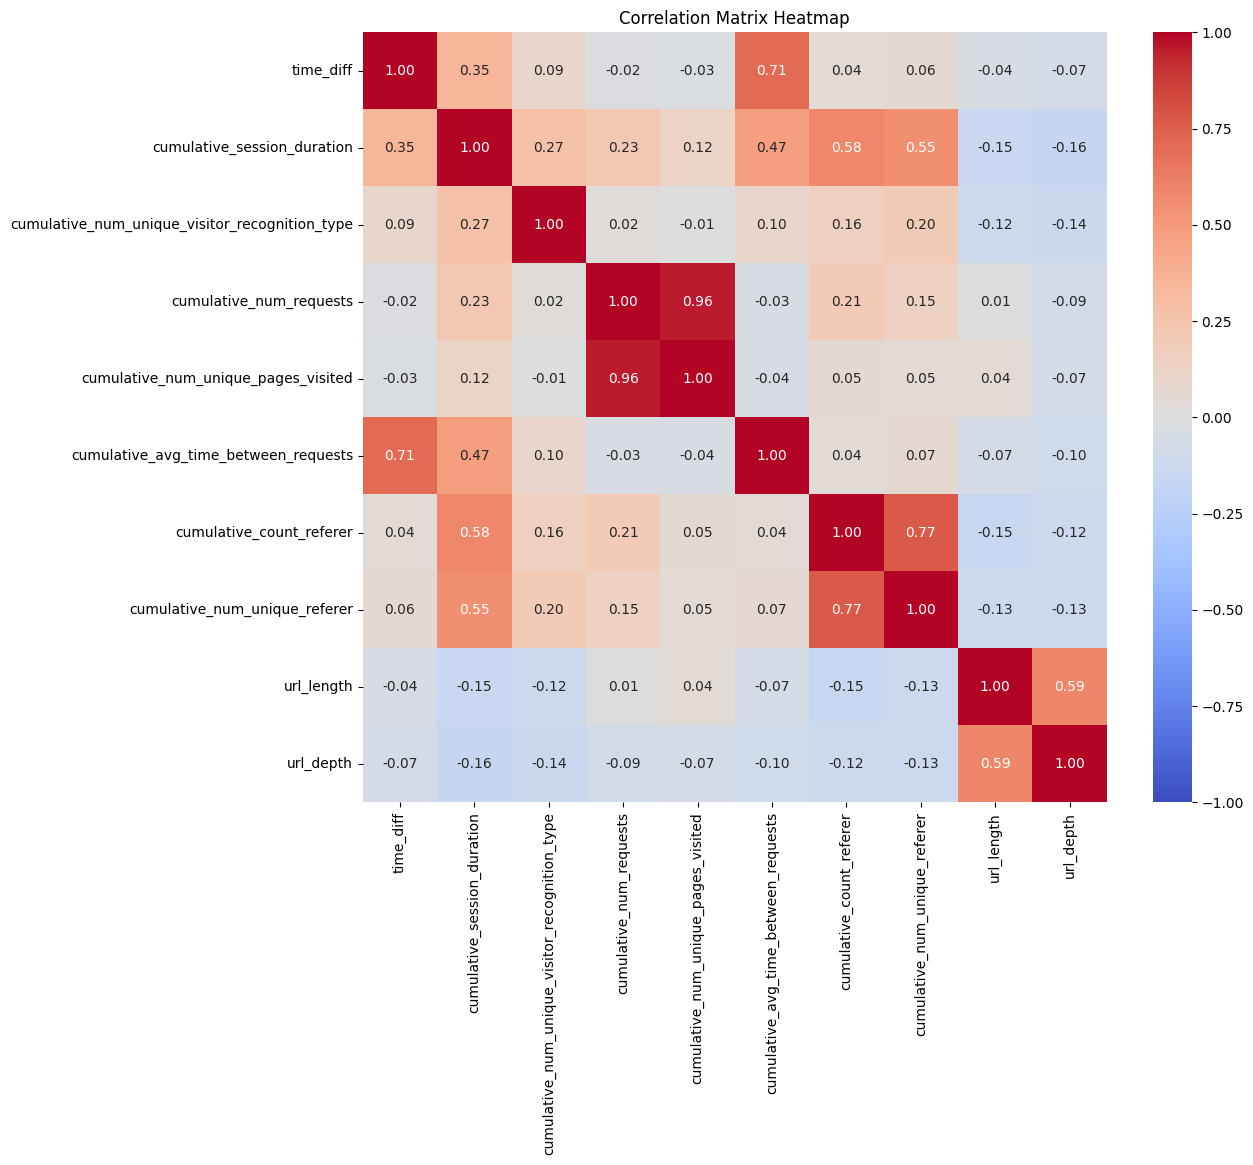

In [10]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Using 0.9 as threshold, keep one between cumulative_num_requests and cumulative_num_unique_pages_visited. 

In [11]:
df = df.drop(columns=['cumulative_num_unique_pages_visited']) # in the production code, this feature will not be derived. 

Logs are not complete!!

In [12]:
df

session_id country_by_ip_address  \
27305  000339eb8412724e0ecd55e695fd5ea1                    US   
27421  00070b81850bd8cf15019f8aa469820c                    US   
30585  0007273f5ce02adbfbc3058f9e801cc5                    US   
59710  0007d22c96b6168fd41b7a5360edee75                    FR   
50929  000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
36050  fff6621ab803217e98f99f7328e46a40                    NL   
57377  fff7b8c890847fff585e61573c3667b5                    US   
49013  fffc13529d0f34dff188b214477e3327                    US   
1977   fffc1c7043c575997dec89551b295b67                    US   
6747   ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
27305                   CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
27421                   CA  https://www.bol.com/nl/p/modern-questions-of-c...   
30585                   CA  https://www.bol.com/nl/c/gabrielli-players/256...   
59710                  NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929                  NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
36050                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
57377                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
49013                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
1977                    CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
6747                    WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
27305                                                NaN   
27421                                                NaN   
30585                                                NaN   
59710  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929  https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
36050                                                NaN   
57377                                                NaN   
49013                                                NaN   
1977                                                 NaN   
6747                                                 NaN   

      visitor_recognition_type ua_agent_class                datetime  \
27305                ANONYMOUS          Robot 2018-03-05 20:19:34.719   
27421                ANONYMOUS          Robot 2018-03-05 20:20:41.010   
30585                ANONYMOUS          Robot 2018-03-05 20:59:56.066   
59710                ANONYMOUS        Browser 2018-03-05 21:58:40.328   
50929               RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
36050                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
57377                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
49013                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
1977                 ANONYMOUS          Robot 2018-03-05 20:22:00.034   
6747                 ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  \
27305        0.0                          0.0   
27421        0.0                          0.0   
30585        0.0                          0.0   
59710        0.0                          0.0   
50929        0.0                          0.0   
...          ...                          ...   
36050        0.0                          0.0   
57377        0.0                          0.0   
49013        0.0                          0.0   
1977         0.0                          0.0   
6747         0.0                          0.0   

       cumulative_num_unique_visitor_recognition_type  \
27305                          

In [13]:
df[df['datetime']==df['datetime'].min()]

session_id country_by_ip_address  \
8498  4a26ed5845d385a9e740aab697f52b17                    NL   

     region_by_ip_address                             url_without_parameters  \
8498                   GR  https://www.bol.com/nl/order/basket_bargains.html   

     referrer_without_parameters visitor_recognition_type ua_agent_class  \
8498                         NaN                ANONYMOUS        Browser   

                    datetime  time_diff  cumulative_session_duration  \
8498 2018-03-05 20:00:00.011        0.0                          0.0   

      cumulative_num_unique_visitor_recognition_type  cumulative_num_requests  \
8498                                               1                        1   

      cumulative_avg_time_between_requests  cumulative_count_referer  \
8498                                   0.0                         0   

      cumulative_num_unique_referer                      url_split  \
8498                              0  [order, basket_bargains.html]   

                      url_string  url_length  url_depth  
8498  order basket_bargains.html          49          5

In [14]:
df[df['session_id']=='4a26ed5845d385a9e740aab697f52b17']

session_id country_by_ip_address  \
8498   4a26ed5845d385a9e740aab697f52b17                    NL   
34233  4a26ed5845d385a9e740aab697f52b17                    NL   
42888  4a26ed5845d385a9e740aab697f52b17                    NL   
17071  4a26ed5845d385a9e740aab697f52b17                    NL   
34311  4a26ed5845d385a9e740aab697f52b17                    NL   
43218  4a26ed5845d385a9e740aab697f52b17                    NL   
51797  4a26ed5845d385a9e740aab697f52b17                    NL   
9080   4a26ed5845d385a9e740aab697f52b17                    NL   
26615  4a26ed5845d385a9e740aab697f52b17                    NL   
1828   4a26ed5845d385a9e740aab697f52b17                    NL   
10318  4a26ed5845d385a9e740aab697f52b17                    NL   
23376  4a26ed5845d385a9e740aab697f52b17                    NL   
14870  4a26ed5845d385a9e740aab697f52b17                    NL   
6482   4a26ed5845d385a9e740aab697f52b17                    NL   
50271  4a26ed5845d385a9e740aab697f52b17                    NL   
15977  4a26ed5845d385a9e740aab697f52b17                    NL   
16030  4a26ed5845d385a9e740aab697f52b17                    NL   
58895  4a26ed5845d385a9e740aab697f52b17                    NL   
16066  4a26ed5845d385a9e740aab697f52b17                    NL   
41956  4a26ed5845d385a9e740aab697f52b17                    NL   
41969  4a26ed5845d385a9e740aab697f52b17                    NL   
51311  4a26ed5845d385a9e740aab697f52b17                    NL   

      region_by_ip_address                             url_without_parameters  \
8498                    GR  https://www.bol.com/nl/order/basket_bargains.html   
34233                   GR  https://www.bol.com/nl/l/algemeen/topdeals/N/4...   
42888                   GR         https://www.bol.com/nl/checkout/login.html   
17071                   GR  https://www.bol.com/nl/order/basket_bargains.html   
34311                   GR  https://www.bol.com/nl/order/basket_bargains.html   
43218                   GR  https://www.bol.com/nl/account/bestellingen/ov...   
51797                   GR  https://www.bol.com/nl/p/smaakvrienden-fruit-z...   
9080                    GR  https://www.bol.com/nl/p/way-it-feels-lp-cd/92...   
26615                   GR  https://www.bol.com/nl/lijstjes/verlanglijstje...   
1828                    GR  https://www.bol.com/nl/p/smaakvrienden-fruit-z...   
10318                   GR  https://www.bol.com/nl/order/basket_bargains.html   
23376                   GR  https://www.bol.com/nl/order/basket_bargains.html   
14870                   GR          https://www.bol.com/nl/account/login.html   
6482                    GR  https://www.bol.com/nl/order/basket_bargains.html   
50271                   GR          https://www.bol.com/nl/checkout/paid.html   
15977                   GR           https://www.bol.com/nl/s/ajax/index.html   
16030                   GR  https://www.bol.com/nl/p/rojafit-luxe-budget-d...   
58895                   GR  https://www.bol.com/nl/order/basket_bargains.html   
16066                   GR  https://www.bol.com/nl/p/rojafit-luxe-budget-d...   
41956                   GR           https://www.bol.com/nl/s/ajax/index.html   
41969                   GR           https://www.bol.com/nl/s/ajax/index.html   
51311                   GR  https://www.bol.com/nl/p/iittala-origo-papiere...   

                             referrer_without_parameters  \
8498                                                 NaN   
34233                                                NaN   
42888                                                NaN   
17071                                                NaN   
34311                                                NaN   
43218       https://www.bol.com/nl/chckout/checkout.html   
51797                                                NaN   
9080                                                 NaN   
26615                                                NaN   
1828                                                 NaN   
10318    

There might be other logs outside the time range. This session is so long!!! two hours!!! usually it is 30 mins

# Feature Engineering -  URL 

In [17]:
from collections import Counter

# Function to get the most frequent k terms
def get_top_k_terms(df, column, k):
    # Flatten the list of lists
    all_terms = [term for sublist in df[column] for term in sublist]
    
    # Count the frequency of each term
    term_counts = Counter(all_terms)
    
    # Get the most common k terms
    top_k_terms = [term for term, _ in term_counts.most_common(k)]
    
    return top_k_terms


In [18]:
k = 10  # Example value for k
top_k_terms = get_top_k_terms(df, 'url_split', k)

print(f"Top {k} terms:")
print(top_k_terms)

Top 10 terms:
['p', 'l', 'N', 'index.html', 'ajax', 'filter_N', 's', 'c', 'ra', 'algemeen']


In [19]:
# Function to create one-hot encoded features for top k terms
def create_one_hot_url_term_features(df, column, top_k_terms):
    # Initialize an empty DataFrame
    one_hot_df = pd.DataFrame(index=df.index)
    
    # Iterate over the top k terms and create one-hot encoded columns
    for term in top_k_terms:
        one_hot_df[f'contains_{term}'] = df[column].apply(lambda x: 1 if term in x else 0)
    
    return one_hot_df

one_hot_df = create_one_hot_url_term_features(df, 'url_split', top_k_terms)

# Concatenate the new one-hot encoded DataFrame with the original DataFrame
df_with_url_one_hot_features = pd.concat([df, one_hot_df], axis=1)


In [20]:
df_with_url_one_hot_features

session_id country_by_ip_address  \
27305  000339eb8412724e0ecd55e695fd5ea1                    US   
27421  00070b81850bd8cf15019f8aa469820c                    US   
30585  0007273f5ce02adbfbc3058f9e801cc5                    US   
59710  0007d22c96b6168fd41b7a5360edee75                    FR   
50929  000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
36050  fff6621ab803217e98f99f7328e46a40                    NL   
57377  fff7b8c890847fff585e61573c3667b5                    US   
49013  fffc13529d0f34dff188b214477e3327                    US   
1977   fffc1c7043c575997dec89551b295b67                    US   
6747   ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
27305                   CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
27421                   CA  https://www.bol.com/nl/p/modern-questions-of-c...   
30585                   CA  https://www.bol.com/nl/c/gabrielli-players/256...   
59710                  NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929                  NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
36050                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
57377                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
49013                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
1977                    CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
6747                    WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
27305                                                NaN   
27421                                                NaN   
30585                                                NaN   
59710  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929  https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
36050                                                NaN   
57377                                                NaN   
49013                                                NaN   
1977                                                 NaN   
6747                                                 NaN   

      visitor_recognition_type ua_agent_class                datetime  \
27305                ANONYMOUS          Robot 2018-03-05 20:19:34.719   
27421                ANONYMOUS          Robot 2018-03-05 20:20:41.010   
30585                ANONYMOUS          Robot 2018-03-05 20:59:56.066   
59710                ANONYMOUS        Browser 2018-03-05 21:58:40.328   
50929               RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
36050                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
57377                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
49013                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
1977                 ANONYMOUS          Robot 2018-03-05 20:22:00.034   
6747                 ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  ...  contains_p  contains_l  \
27305        0.0                          0.0  ...           0           1   
27421        0.0                          0.0  ...           1           0   
30585        0.0                          0.0  ...           0           0   
59710        0.0                          0.0  ...           1           0   
50929        0.0                          0.0  ...           0           0   
...          ...                          ...  ...         ...         ...   
36050        0.0                          0.0  ...           1           0   
57377        0.0                          0.0  ...   

## Tuning `k` (top-k frequent terms in url)

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

In [22]:
# Function to perform session-based stratified splitting
def session_based_stratified_split(df, n_splits=5):
    # Extract unique session IDs and their corresponding ua_agent_class
    session_class = df.groupby('session_id')['ua_agent_class'].first().reset_index()
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Generate session-based splits
    splits = []
    for train_idx, val_idx in skf.split(session_class['session_id'], session_class['ua_agent_class']):
        train_sessions = session_class['session_id'].iloc[train_idx]
        val_sessions = session_class['session_id'].iloc[val_idx]
        
        train_df = df[df['session_id'].isin(train_sessions)]
        val_df = df[df['session_id'].isin(val_sessions)]
        
        splits.append((train_df, val_df))
    
    return splits

In [23]:
# Function to evaluate the model with different k values using session-based stratified cross-validation
def evaluate_k_values(df, target_column, k_values, n_splits=5, metric='f1'):
    results = {}
    
    for k in k_values:
        top_k_terms = get_top_k_terms(df, 'url_split', k)
        one_hot_df = create_one_hot_url_term_features(df, 'url_split', top_k_terms)
        
        # Concatenate the new one-hot encoded DataFrame with the original DataFrame
        df_with_features = pd.concat([df, one_hot_df], axis=1)

        splits = session_based_stratified_split(df_with_features, n_splits=n_splits)
        
        # Initialize the classifier
        clf = RandomForestClassifier(random_state=42)
        
        fold_scores = []
        
        for train_df, val_df in splits:
            # Prepare the feature matrix and target vector
            X_train = train_df[[f'contains_{term}' for term in top_k_terms]]
            y_train = train_df[target_column]
            X_val = val_df[[f'contains_{term}' for term in top_k_terms]]
            y_val = val_df[target_column]
            
            # Train the model
            clf.fit(X_train, y_train)
            
            # Validate the model
            y_pred = clf.predict(X_val)
            if metric == 'f1':
                score = f1_score(y_val, y_pred, average='weighted')
            elif metric == 'auprc':
                # Convert labels to binary format for AU-PRC calculation
                y_val_bin = label_binarize(y_val, classes=clf.classes_)
                y_pred_prob = clf.predict_proba(X_val)
                score = average_precision_score(y_val_bin, y_pred_prob, average='weighted')
            else:
                raise ValueError(f"Unsupported metric: {metric}")
            fold_scores.append(score)
        
        # Average score across all folds
        results[k] = np.mean(fold_scores)
    
    return results

# Example target column (adjust as needed)
target_column = 'ua_agent_class'

# Define a range of k values to test
k_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

# Evaluate the model with different k values using F1 score
k_results_f1 = evaluate_k_values(df, target_column, k_values, metric='f1')

# Evaluate the model with different k values using AU-PRC
k_results_auprc = evaluate_k_values(df, target_column, k_values, metric='auprc')

# Display the results
print("Evaluation results for different k values using F1 score:")
for k, score in k_results_f1.items():
    print(f"k={k}: F1 score={score:.4f}")

print("\nEvaluation results for different k values using AU-PRC:")
for k, score in k_results_auprc.items():
    print(f"k={k}: AU-PRC={score:.4f}")


/var/folders/52/s39mvkts1fjbr1vq030jrx280000gn/T/ipykernel_75595/3361614330.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[f'contains_{term}'] = df[column].apply(lambda x: 1 if term in x else 0)
/var/folders/52/s39mvkts1fjbr1vq030jrx280000gn/T/ipykernel_75595/3361614330.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_df[f'contains_{term}'] = df[column].apply(lambda x: 1 if term in x else 0)
/var/folders/52/s39mvkts1fjbr1vq030jrx280000gn/T/ipykernel_75595/3361614330.py:8: PerformanceWarning: DataFrame 

Evaluation results for different k values using F1 score:
k=10: F1 score=0.7908
k=20: F1 score=0.7917
k=30: F1 score=0.8080
k=40: F1 score=0.8081
k=50: F1 score=0.8081
k=60: F1 score=0.8089
k=70: F1 score=0.8117
k=80: F1 score=0.8121
k=90: F1 score=0.8120
k=100: F1 score=0.8129
k=200: F1 score=0.8160

Evaluation results for different k values using AU-PRC:
k=10: AU-PRC=0.8027
k=20: AU-PRC=0.8081
k=30: AU-PRC=0.8226
k=40: AU-PRC=0.8232
k=50: AU-PRC=0.8237
k=60: AU-PRC=0.8243
k=70: AU-PRC=0.8272
k=80: AU-PRC=0.8276
k=90: AU-PRC=0.8280
k=100: AU-PRC=0.8282
k=200: AU-PRC=0.8324


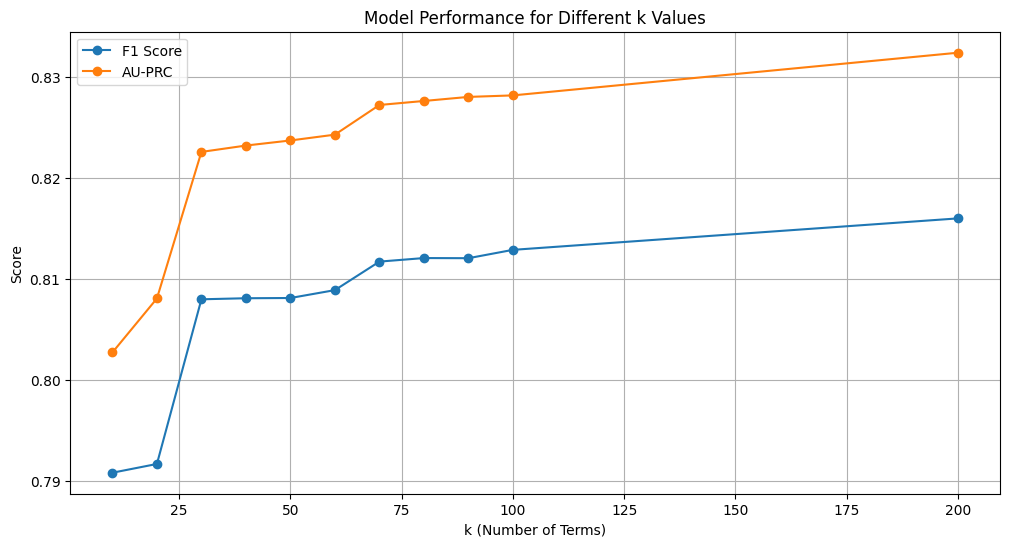

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, [k_results_f1[k] for k in k_values], marker='o', label='F1 Score')
plt.plot(k_values, [k_results_auprc[k] for k in k_values], marker='o', label='AU-PRC')
plt.xlabel('k (Number of Terms)')
plt.ylabel('Score')
plt.title('Model Performance for Different k Values')
plt.legend()
plt.grid(True)
plt.show()


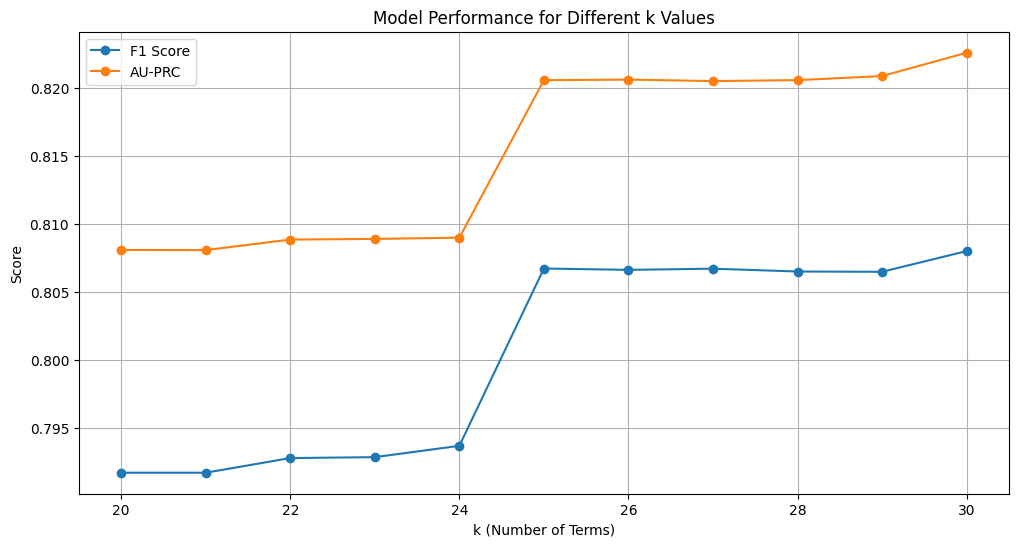

In [25]:
k_values = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

# Evaluate the model with different k values using F1 score
k_results_f1 = evaluate_k_values(df, target_column, k_values, metric='f1')

# Evaluate the model with different k values using AU-PRC
k_results_auprc = evaluate_k_values(df, target_column, k_values, metric='auprc')

plt.figure(figsize=(12, 6))
plt.plot(k_values, [k_results_f1[k] for k in k_values], marker='o', label='F1 Score')
plt.plot(k_values, [k_results_auprc[k] for k in k_values], marker='o', label='AU-PRC')
plt.xlabel('k (Number of Terms)')
plt.ylabel('Score')
plt.title('Model Performance for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion**: 

Although k=200 gives the best performance, considering its high cardinality, choose a k that can bring the higher marginal improvements. 

Based on the plot, 𝑘=25 is a balanced choice as it provides a good trade-off between performance and model complexity. This choice captures most of the improvement without introducing unnecessary complexity.

In [26]:
df.columns

Index(['session_id', 'country_by_ip_address', 'region_by_ip_address',
       'url_without_parameters', 'referrer_without_parameters',
       'visitor_recognition_type', 'ua_agent_class', 'datetime', 'time_diff',
       'cumulative_session_duration',
       'cumulative_num_unique_visitor_recognition_type',
       'cumulative_num_requests', 'cumulative_avg_time_between_requests',
       'cumulative_count_referer', 'cumulative_num_unique_referer',
       'url_split', 'url_string', 'url_length', 'url_depth'],
      dtype='object')

In [27]:
k = 25  # Example value for k
top_k_terms = get_top_k_terms(df, 'url_split', k)

one_hot_df = create_one_hot_url_term_features(df, 'url_split', top_k_terms)
df_with_url_one_hot_features = pd.concat([df, one_hot_df], axis=1)

In [28]:
df_with_url_one_hot_features

session_id country_by_ip_address  \
27305  000339eb8412724e0ecd55e695fd5ea1                    US   
27421  00070b81850bd8cf15019f8aa469820c                    US   
30585  0007273f5ce02adbfbc3058f9e801cc5                    US   
59710  0007d22c96b6168fd41b7a5360edee75                    FR   
50929  000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
36050  fff6621ab803217e98f99f7328e46a40                    NL   
57377  fff7b8c890847fff585e61573c3667b5                    US   
49013  fffc13529d0f34dff188b214477e3327                    US   
1977   fffc1c7043c575997dec89551b295b67                    US   
6747   ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
27305                   CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
27421                   CA  https://www.bol.com/nl/p/modern-questions-of-c...   
30585                   CA  https://www.bol.com/nl/c/gabrielli-players/256...   
59710                  NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929                  NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
36050                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
57377                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
49013                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
1977                    CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
6747                    WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
27305                                                NaN   
27421                                                NaN   
30585                                                NaN   
59710  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929  https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
36050                                                NaN   
57377                                                NaN   
49013                                                NaN   
1977                                                 NaN   
6747                                                 NaN   

      visitor_recognition_type ua_agent_class                datetime  \
27305                ANONYMOUS          Robot 2018-03-05 20:19:34.719   
27421                ANONYMOUS          Robot 2018-03-05 20:20:41.010   
30585                ANONYMOUS          Robot 2018-03-05 20:59:56.066   
59710                ANONYMOUS        Browser 2018-03-05 21:58:40.328   
50929               RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
36050                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
57377                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
49013                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
1977                 ANONYMOUS          Robot 2018-03-05 20:22:00.034   
6747                 ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  ...  contains_account  \
27305        0.0                          0.0  ...                 0   
27421        0.0                          0.0  ...                 0   
30585        0.0                          0.0  ...                 0   
59710        0.0                          0.0  ...                 0   
50929        0.0                          0.0  ...                 0   
...          ...                          ...  ...               ...   
36050        0.0                          0.0  ...                 0   
57377        0.0                          0.0  ...                 0   
49013        0.0             

In [29]:
df_with_url_one_hot_features.dtypes

session_id                                                object
country_by_ip_address                                     object
region_by_ip_address                                      object
url_without_parameters                                    object
referrer_without_parameters                               object
visitor_recognition_type                                  object
ua_agent_class                                            object
datetime                                          datetime64[ns]
time_diff                                                float64
cumulative_session_duration                              float64
cumulative_num_unique_visitor_recognition_type             int64
cumulative_num_requests                                    int64
cumulative_avg_time_between_requests                     float64
cumulative_count_referer                                   int64
cumulative_num_unique_referer                              int64
url_split                

# Feature Engineering - categorical features

Summery:



In [30]:
df['country_by_ip_address'].value_counts()

country_by_ip_address
NL    25673
US    22780
BE     7409
GB     1185
DE      616
      ...  
MC        1
MX        1
CW        1
MN        1
SK        1
Name: count, Length: 65, dtype: int64

In [31]:
df['region_by_ip_address'].value_counts()

region_by_ip_address
CA     20662
NH      4320
ZH      4160
VAN     2239
NB      2112
       ...  
33         1
DL         1
202        1
29         1
GI         1
Name: count, Length: 228, dtype: int64

Check if country_by_ip_address and region_by_ip_address are highly correlated.

In [32]:
import pandas as pd
from scipy.stats import chi2_contingency

# Contingency table
contingency_table = pd.crosstab(df['country_by_ip_address'], df['region_by_ip_address'])

# Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')


Chi-square statistic: 2565897.4171861643
p-value: 0.0


The result of the chi-square test indicates a very strong association between country_by_ip_address and region_by_ip_address. This implies that knowing the country can give significant information about the region and vice versa.

However, deciding whether to use only country_by_ip_address should be based on more than just this correlation. Here are a few more points to consider:

- Predictive Power: If regions within countries provide additional predictive power beyond what the country alone provides, it may still be beneficial to include regions.
- Model Performance: Evaluate the performance of models with just country_by_ip_address vs. both country_by_ip_address and region_by_ip_address to see if there is a significant difference.
- Cardinality Handling: handle the high cardinality effectively.

**Frequency Encoding**

Frequency encoding replaces each category with its frequency, which works well with tree-based models and helps manage high cardinality. Check my blog for more details: [blog link](https://medium.com/@SiqiLi/frequency-encoding-4156b92e7942)

**Label Encoding**

Label encoding assigns a unique integer to each category, which is straightforward but less effective for high-cardinality categorical features.

In [33]:
df_tmp = df_with_url_one_hot_features.copy()

In [34]:
# Frequency encoding for 'country_by_ip_address'
frequency_country = df_tmp['country_by_ip_address'].value_counts()
df_tmp['country_frequency_encoded'] = df_tmp['country_by_ip_address'].map(frequency_country)

# Frequency encoding for 'region_by_ip_address'
frequency_region = df_tmp['region_by_ip_address'].value_counts()
df_tmp['region_frequency_encoded'] = df_tmp['region_by_ip_address'].map(frequency_region)

In [35]:
df_tmp

session_id country_by_ip_address  \
27305  000339eb8412724e0ecd55e695fd5ea1                    US   
27421  00070b81850bd8cf15019f8aa469820c                    US   
30585  0007273f5ce02adbfbc3058f9e801cc5                    US   
59710  0007d22c96b6168fd41b7a5360edee75                    FR   
50929  000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
36050  fff6621ab803217e98f99f7328e46a40                    NL   
57377  fff7b8c890847fff585e61573c3667b5                    US   
49013  fffc13529d0f34dff188b214477e3327                    US   
1977   fffc1c7043c575997dec89551b295b67                    US   
6747   ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
27305                   CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
27421                   CA  https://www.bol.com/nl/p/modern-questions-of-c...   
30585                   CA  https://www.bol.com/nl/c/gabrielli-players/256...   
59710                  NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929                  NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
36050                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
57377                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
49013                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
1977                    CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
6747                    WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
27305                                                NaN   
27421                                                NaN   
30585                                                NaN   
59710  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929  https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
36050                                                NaN   
57377                                                NaN   
49013                                                NaN   
1977                                                 NaN   
6747                                                 NaN   

      visitor_recognition_type ua_agent_class                datetime  \
27305                ANONYMOUS          Robot 2018-03-05 20:19:34.719   
27421                ANONYMOUS          Robot 2018-03-05 20:20:41.010   
30585                ANONYMOUS          Robot 2018-03-05 20:59:56.066   
59710                ANONYMOUS        Browser 2018-03-05 21:58:40.328   
50929               RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
36050                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
57377                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
49013                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
1977                 ANONYMOUS          Robot 2018-03-05 20:22:00.034   
6747                 ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  ...  contains_w  \
27305        0.0                          0.0  ...           0   
27421        0.0                          0.0  ...           0   
30585        0.0                          0.0  ...           0   
59710        0.0                          0.0  ...           0   
50929        0.0                          0.0  ...           0   
...          ...                          ...  ...         ...   
36050        0.0                          0.0  ...           0   
57377        0.0                          0.0  ...           0   
49013        0.0                          0.0  ...           0   
1977         0.0 

In [36]:
# Frequency encoding for 'visitor_recognition_type'
frequency_visitor_recognition_type = df_tmp['visitor_recognition_type'].value_counts()
df_tmp['visitor_recognition_type_frequency_encoded'] = df_tmp['visitor_recognition_type'].map(frequency_visitor_recognition_type)

splits = session_based_stratified_split(df_tmp, n_splits=5)
fold_scores = []

for train_df, val_df in splits:
    # Prepare the feature matrix and target vector
    X_train = train_df[['visitor_recognition_type_frequency_encoded']]
    y_train = train_df['ua_agent_class']
    X_val = val_df[['visitor_recognition_type_frequency_encoded']]
    y_val = val_df['ua_agent_class']

    # Train the model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Validate the model
    y_pred = clf.predict(X_val)

    score = f1_score(y_val, y_pred, average='weighted')
   
    fold_scores.append(score)

# Display the results
print("Evaluation results:")
print(f"F1 score={np.mean(fold_scores):.4f}")

Evaluation results:
F1 score=0.5207


In [37]:
# just curious with one-hot encoding


# One-hot encoding for 'visitor_recognition_type'
visitor_recognition_one_hot = pd.get_dummies(df_tmp['visitor_recognition_type'], drop_first=True)
df_tmp = pd.concat([df_tmp, visitor_recognition_one_hot], axis=1)

# Define the feature columns
feature_columns = list(visitor_recognition_one_hot.columns)

splits = session_based_stratified_split(df_tmp, n_splits=5)

fold_scores = []

for train_df, val_df in splits:
    # Prepare the feature matrix and target vector
    X_train = train_df[feature_columns]
    y_train = train_df['ua_agent_class']
    X_val = val_df[feature_columns]
    y_val = val_df['ua_agent_class']

    # Train the model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Validate the model
    y_pred = clf.predict(X_val)

    score = f1_score(y_val, y_pred, average='weighted')
   
    fold_scores.append(score)

# Display the results
print("Evaluation results:")
print(f"F1 score={np.mean(fold_scores):.4f}")



Evaluation results:
F1 score=0.5207


Exactly the same performance!!!!

In [38]:
def evaluate_features(df, feature_columns, target_column):

    splits = session_based_stratified_split(df, n_splits=5)

    fold_scores = []

    for train_df, val_df in splits:
        # Prepare the feature matrix and target vector
        X_train = train_df[feature_columns]
        y_train = train_df[target_column]
        X_val = val_df[feature_columns]
        y_val = val_df[target_column]

        # Train the model
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
        
        # Validate the model
        y_pred = clf.predict(X_val)

        score = f1_score(y_val, y_pred, average='weighted')
    
        fold_scores.append(score)

    # Display the results
    print(f"Evaluation features: {feature_columns}")
    print(f"F1 score={np.mean(fold_scores):.4f}")

In [39]:
feature_columns = ['country_frequency_encoded','region_frequency_encoded']+list(visitor_recognition_one_hot.columns)
evaluate_features(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['country_frequency_encoded', 'region_frequency_encoded', 'LOGGEDIN', 'RECOGNIZED']
F1 score=0.9598


In [40]:
feature_columns = ['country_frequency_encoded','region_frequency_encoded']
evaluate_features(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['country_frequency_encoded', 'region_frequency_encoded']
F1 score=0.9593


In [41]:
feature_columns = ['country_frequency_encoded']
evaluate_features(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['country_frequency_encoded']
F1 score=0.9408


In [42]:
feature_columns = ['region_frequency_encoded']
evaluate_features(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['region_frequency_encoded']
F1 score=0.9563


In [43]:
df_tmp

session_id country_by_ip_address  \
27305  000339eb8412724e0ecd55e695fd5ea1                    US   
27421  00070b81850bd8cf15019f8aa469820c                    US   
30585  0007273f5ce02adbfbc3058f9e801cc5                    US   
59710  0007d22c96b6168fd41b7a5360edee75                    FR   
50929  000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
36050  fff6621ab803217e98f99f7328e46a40                    NL   
57377  fff7b8c890847fff585e61573c3667b5                    US   
49013  fffc13529d0f34dff188b214477e3327                    US   
1977   fffc1c7043c575997dec89551b295b67                    US   
6747   ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
27305                   CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
27421                   CA  https://www.bol.com/nl/p/modern-questions-of-c...   
30585                   CA  https://www.bol.com/nl/c/gabrielli-players/256...   
59710                  NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929                  NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
36050                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
57377                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
49013                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
1977                    CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
6747                    WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
27305                                                NaN   
27421                                                NaN   
30585                                                NaN   
59710  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
50929  https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
36050                                                NaN   
57377                                                NaN   
49013                                                NaN   
1977                                                 NaN   
6747                                                 NaN   

      visitor_recognition_type ua_agent_class                datetime  \
27305                ANONYMOUS          Robot 2018-03-05 20:19:34.719   
27421                ANONYMOUS          Robot 2018-03-05 20:20:41.010   
30585                ANONYMOUS          Robot 2018-03-05 20:59:56.066   
59710                ANONYMOUS        Browser 2018-03-05 21:58:40.328   
50929               RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
36050                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
57377                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
49013                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
1977                 ANONYMOUS          Robot 2018-03-05 20:22:00.034   
6747                 ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  ...  contains_paid.html  \
27305        0.0                          0.0  ...                   0   
27421        0.0                          0.0  ...                   0   
30585        0.0                          0.0  ...                   0   
59710        0.0                          0.0  ...                   0   
50929        0.0                          0.0  ...                   0   
...          ...                          ...  ...                 ...   
36050        0.0                          0.0  ...                   0   
57377        0.0                          0.0  ...                   0   
49013      

In [44]:
df_tmp.dtypes

session_id                                                object
country_by_ip_address                                     object
region_by_ip_address                                      object
url_without_parameters                                    object
referrer_without_parameters                               object
visitor_recognition_type                                  object
ua_agent_class                                            object
datetime                                          datetime64[ns]
time_diff                                                float64
cumulative_session_duration                              float64
cumulative_num_unique_visitor_recognition_type             int64
cumulative_num_requests                                    int64
cumulative_avg_time_between_requests                     float64
cumulative_count_referer                                   int64
cumulative_num_unique_referer                              int64
url_split                

In [45]:
df_tmp = df_tmp.drop(columns=['visitor_recognition_type_frequency_encoded']) # in the production code, this feature will not be derived. 

In [46]:
feature_columns = df_tmp.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()
evaluate_features(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['time_diff', 'cumulative_session_duration', 'cumulative_num_unique_visitor_recognition_type', 'cumulative_num_requests', 'cumulative_avg_time_between_requests', 'cumulative_count_referer', 'cumulative_num_unique_referer', 'url_length', 'url_depth', 'contains_p', 'contains_l', 'contains_N', 'contains_index.html', 'contains_ajax', 'contains_filter_N', 'contains_s', 'contains_c', 'contains_ra', 'contains_algemeen', 'contains_order', 'contains_basket_bargains.html', 'contains_login.html', 'contains_checkout', 'contains_zoekresultaten', 'contains_account', 'contains_sc', 'contains_w', 'contains_media_all', 'contains_boeken', 'contains_paid.html', 'contains_elektronica', 'contains_t', 'contains_b', 'contains_iets', 'country_frequency_encoded', 'region_frequency_encoded', 'LOGGEDIN', 'RECOGNIZED']
F1 score=0.9840


# Feature Importance Analysis

In [58]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def evaluate_features_importance(df, feature_columns, target_column):
    splits = session_based_stratified_split(df, n_splits=5)

    fold_scores = []
    importances = np.zeros(len(feature_columns))  # Initialize an array to accumulate importances

    for train_df, val_df in splits:
        # Prepare the feature matrix and target vector
        X_train = train_df[feature_columns]
        y_train = train_df[target_column]
        X_val = val_df[feature_columns]
        y_val = val_df[target_column]

        # Train the model
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
        
        # Validate the model
        y_pred = clf.predict(X_val)

        score = f1_score(y_val, y_pred, average='weighted')
        fold_scores.append(score)
        
        # Accumulate feature importances
        fold_importances = clf.feature_importances_
        importances += fold_importances

    # Average the importances across all folds
    importances /= len(splits)

    # Create a DataFrame for easy viewing
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Display the results
    print(f"Evaluation features: {feature_columns}")
    print(f"F1 score={np.mean(fold_scores):.4f}")
    print("\nFeature importances:")
    print(feature_importance_df)

    return feature_importance_df  # Return the DataFrame for further analysis


In [59]:
feature_columns = df_tmp.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()
feature_importance_df = evaluate_features_importance(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['time_diff', 'cumulative_session_duration', 'cumulative_num_unique_visitor_recognition_type', 'cumulative_num_requests', 'cumulative_avg_time_between_requests', 'cumulative_count_referer', 'cumulative_num_unique_referer', 'url_length', 'url_depth', 'contains_p', 'contains_l', 'contains_N', 'contains_index.html', 'contains_ajax', 'contains_filter_N', 'contains_s', 'contains_c', 'contains_ra', 'contains_algemeen', 'contains_order', 'contains_basket_bargains.html', 'contains_login.html', 'contains_checkout', 'contains_zoekresultaten', 'contains_account', 'contains_sc', 'contains_w', 'contains_media_all', 'contains_boeken', 'contains_paid.html', 'contains_elektronica', 'contains_t', 'contains_b', 'contains_iets', 'country_frequency_encoded', 'region_frequency_encoded', 'LOGGEDIN', 'RECOGNIZED']
F1 score=0.9840

Feature importances:
                                           Feature  Importance
35                        region_frequency_encoded    0.315625
34          

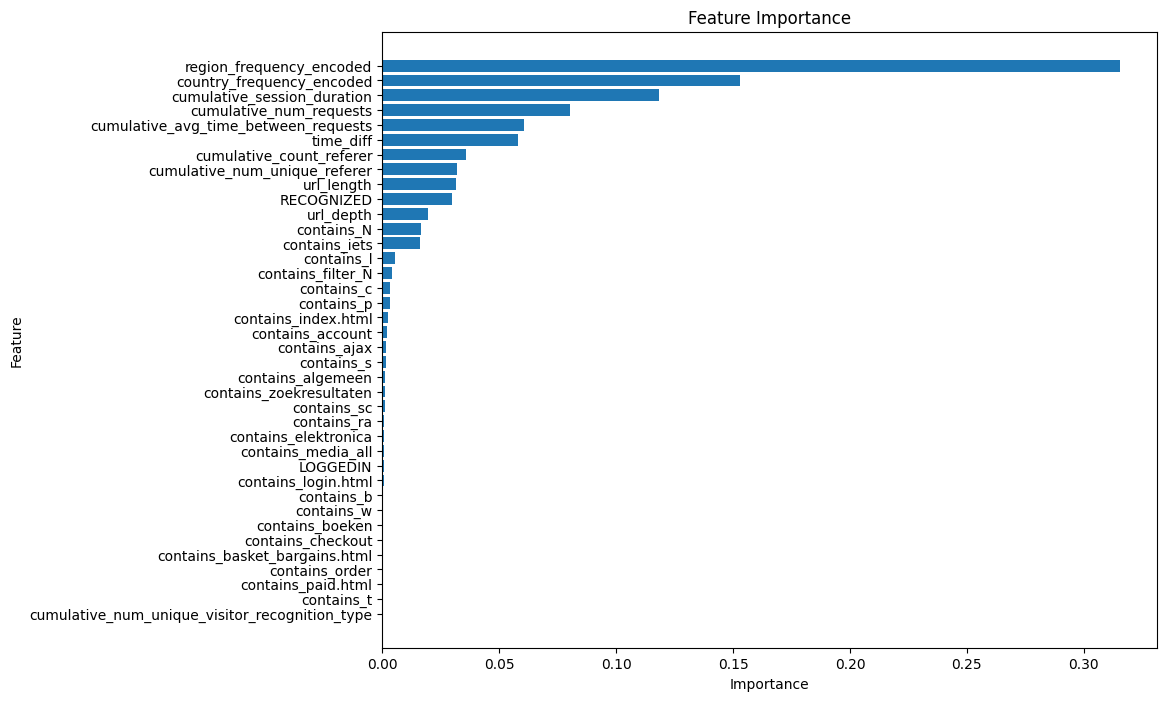

In [60]:
# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


cumulative_num_unique_visitor_recognition_type will not be included in the final model. 

In [63]:
feature_columns = [item for item in df_tmp.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist() if item not in ['cumulative_num_unique_visitor_recognition_type']]
feature_importance_df = evaluate_features_importance(df_tmp, feature_columns,'ua_agent_class')

Evaluation features: ['time_diff', 'cumulative_session_duration', 'cumulative_num_requests', 'cumulative_avg_time_between_requests', 'cumulative_count_referer', 'cumulative_num_unique_referer', 'url_length', 'url_depth', 'contains_p', 'contains_l', 'contains_N', 'contains_index.html', 'contains_ajax', 'contains_filter_N', 'contains_s', 'contains_c', 'contains_ra', 'contains_algemeen', 'contains_order', 'contains_basket_bargains.html', 'contains_login.html', 'contains_checkout', 'contains_zoekresultaten', 'contains_account', 'contains_sc', 'contains_w', 'contains_media_all', 'contains_boeken', 'contains_paid.html', 'contains_elektronica', 'contains_t', 'contains_b', 'contains_iets', 'country_frequency_encoded', 'region_frequency_encoded', 'LOGGEDIN', 'RECOGNIZED']
F1 score=0.9840

Feature importances:
                                 Feature  Importance
34              region_frequency_encoded    0.334608
33             country_frequency_encoded    0.167563
2                cumulative_n

Now I am clear with all the features. f1-score = 0.9840 will be the new benchmark. Tuning model hyperparameters in the next notebook.